In [1]:
!pip install scikit-optimize
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from skopt import gp_minimize
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc,plot_confusion_matrix

## Importing & preprocessing

In [2]:
#importing the dataset
df = pd.read_csv('data_issold.csv')

In [3]:
x = pd.get_dummies(df.auction_fee_tax_rate, prefix='auction_fee_tax_rate')
df = pd.concat([df, x], axis=1)
df = df.drop(['auction_fee_tax_rate', 'increment_type_nl Biedrange 0-15 1 euro (Beuknoot)'], axis=1)

In [4]:
y = df['is_sold']
X = df.drop(['is_sold'], axis=1)
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('The shape of our data is:', df.shape)
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', X_test.shape)
print('Testing Features Shape:', y_train.shape)
print('Testing Labels Shape:', y_test.shape)

The shape of our data is: (66271, 44)
Training Features Shape: (53016, 43)
Training Labels Shape: (13255, 43)
Testing Features Shape: (53016,)
Testing Labels Shape: (13255,)


In [5]:
classifier = GradientBoostingClassifier()
numerical = ['start_amount', 'bidding_window']

## Optimization with skopt

In [6]:
#Building a pipeline
def build_pipeline(classifier, numerical):
    cat_pipe = make_pipeline(SimpleImputer(strategy='mean'))
    num_pipe = make_pipeline(MinMaxScaler()) 
    transform = make_column_transformer((num_pipe, numerical), remainder=cat_pipe)
    return Pipeline(steps=[('preprocess', transform), ('cls', classifier)])

In [7]:
pipe = build_pipeline(classifier, numerical)

space  = [Real(10**-5, 10**0, "log-uniform", name='cls__learning_rate'),
          Integer(100, 1000, name='cls__n_estimators'), Integer(2, 5, name='cls__max_depth')]

@use_named_args(space)
def objective(**params):
    pipe.set_params(**params)

    return -np.mean(cross_val_score(pipe, X, y, cv=5, n_jobs=-1,
                                    scoring='accuracy'))

In [11]:
######################################################################################
#Do not run this, will take about 1h, optimal parameters are alresdy specified below
######################################################################################


res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

"Best score=%.4f" % res_gp.fun

print("""Best parameters:
- learning_rate=%.6f
- mn_estimators=%d
- max_depth=%d""" % (res_gp.x[0], res_gp.x[1]))

TypeError: not all arguments converted during string formatting

In [14]:
print("""Best parameters:
- learning_rate=%.6f
- mn_estimators=%d
- max_depth=%d""" % (res_gp.x[0], res_gp.x[1], res_gp.x[2]))

Best parameters:
- learning_rate=0.064818
- mn_estimators=1000
- max_depth=5


## Model evaluation

In [12]:
res_gp

          fun: -0.894916405953788
    func_vals: array([-0.8869944 , -0.89275863, -0.60171116, -0.8298654 , -0.81187858,
       -0.88608903, -0.60171116, -0.89419212, -0.8903443 , -0.87591869,
       -0.89017828, -0.89441847, -0.89048008, -0.88863915, -0.60171116,
       -0.87293099, -0.89303022, -0.89379979, -0.88749245, -0.88907676,
       -0.89031414, -0.82936742, -0.87961567, -0.89269824, -0.89469008,
       -0.89465987, -0.88802059, -0.89238136, -0.8939205 , -0.86205141,
       -0.89315094, -0.88613435, -0.89369416, -0.89446372, -0.87142203,
       -0.89465989, -0.89296986, -0.89034432, -0.88651158, -0.89455427,
       -0.89271336, -0.89491641, -0.60171116, -0.89229082, -0.89354327,
       -0.89419209, -0.82093251, -0.87908752, -0.89396577, -0.89431284])
       models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=Tr

In [15]:
classifier = GradientBoostingClassifier(learning_rate=0.064818, n_estimators=1000, max_depth=5)
model = build_pipeline(classifier, numerical)
model = model.fit(X_train, y_train)

In [16]:
acc = accuracy_score(y_test, model.predict(X_test))
prec = precision_score(y_test, model.predict(X_test))
rec = recall_score(y_test, model.predict(X_test))
f1 = f1_score(y_test, model.predict(X_test))
roc = roc_auc_score(y_test, model.predict(X_test))
print("The accuracy on test set: {:.4f}".format(acc))
print("The precision on test set: {:.4f}".format(prec))
print("The recall on test set: {:.4f}".format(rec))
print("The F1 score on test set: {:.4f}".format(f1))
print("The ROC AUC score on test set: {:.4f}".format(roc))

The accuracy on test set: 0.8963
The precision on test set: 0.8988
The recall on test set: 0.9328
The F1 score on test set: 0.9155
The ROC AUC score on test set: 0.8870


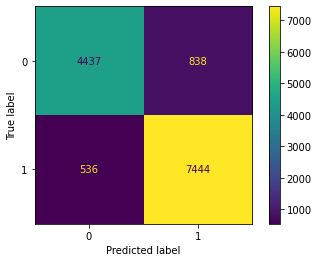

In [17]:
def Performance_conf(Model,X,Y,loc):
    plot_confusion_matrix(Model,X,Y)
    plt.savefig(loc)
    plt.show()
    
Performance_conf(model,X_test,y_test,loc='CM_boosting.png')

No Skill: ROC AUC=0.500
Gradient Boosting: ROC AUC=0.924


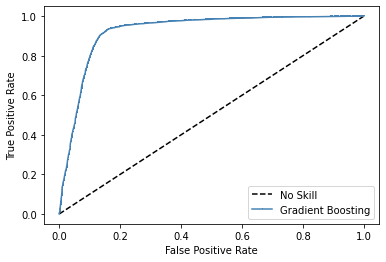

In [18]:
def plot_ROC(Model,X,Y,loc):
    loc='ROC_boosting.png'
    ns_probs = [0 for _ in range(len(y_test))]
    lr_probs = model.predict_proba(X_test)
    lr_probs = lr_probs[:, 1]
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Gradient Boosting: ROC AUC=%.3f' % (lr_auc))
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill', color='black')
    plt.plot(lr_fpr, lr_tpr, marker=',', label='Gradient Boosting', color = 'steelblue')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.savefig(loc)
    plt.show()
plot_ROC(model,X_test,y_test,loc='ROC_boosting.png')

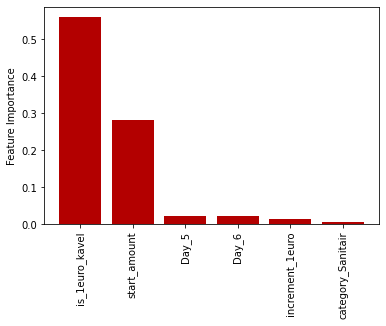

In [19]:
imp = model.named_steps.cls.feature_importances_
cols = X.columns.tolist()
df_imp = {'Features':cols,'Importance':imp}
df_imp = pd.DataFrame(df_imp)
df_imp = df_imp.sort_values(by=['Importance'], ascending = False)

plt.figure()
plt.bar(df_imp.iloc[:6 , 0], df_imp.iloc[:6, 1],color=(0.7,0,0,1))
plt.ylabel("Feature Importance")
plt.xticks(rotation=90)
plt.savefig('GB Feature importance.png',bbox_inches='tight')
plt.show()

In [20]:
X2 = X[['is_1euro_kavel', 'start_amount', 'Day_6', 'increment_1euro', 'sourcing_company_bva', 'is_homedelivery']]
X_train,X_test,y_train,y_test = train_test_split(X2, y, test_size=0.2, random_state=42)

In [23]:
numerical = ['start_amount']
classifier = GradientBoostingClassifier(learning_rate=0.064818, n_estimators=1000, max_depth=5)
model = build_pipeline(classifier, numerical)
model = model.fit(X_train, y_train)

In [24]:
acc = accuracy_score(y_test, model.predict(X_test))
prec = precision_score(y_test, model.predict(X_test))
rec = recall_score(y_test, model.predict(X_test))
f1 = f1_score(y_test, model.predict(X_test))
roc = roc_auc_score(y_test, model.predict(X_test))
print("The accuracy on test set: {:.4f}".format(acc))
print("The precision on test set: {:.4f}".format(prec))
print("The recall on test set: {:.4f}".format(rec))
print("The F1 score on test set: {:.4f}".format(f1))
print("The ROC AUC score on test set: {:.4f}".format(roc))

The accuracy on test set: 0.8041
The precision on test set: 0.8296
The recall on test set: 0.8490
The F1 score on test set: 0.8392
The ROC AUC score on test set: 0.7926


In [3]:
list(df.columns)

['auction_fee_tax_rate',
 'is_1euro_kavel',
 'is_sold',
 'start_amount',
 'bidding_window',
 'is_homedelivery',
 'is_public',
 'is_automatic_credit',
 'category_Accu-/ elektrisch gereedschap',
 'category_Auto-onderdelen en accessoires',
 'category_Computers en Software',
 'category_Dameskleding en -schoenen',
 'category_Herenkleding en -schoenen',
 'category_Horloges',
 'category_Kantoorinrichting',
 'category_Other',
 'category_Sanitair',
 'category_Sieraden',
 'category_Slapen',
 'category_Tuin en terras',
 'category_Unisex',
 'category_Verlichting',
 'category_Woninginrichting',
 'condition_New',
 'condition_Old',
 'seller_type_New Seller',
 'seller_type_Seller',
 'increment_type_nl Biedrange 0-15 1 euro (Beuknoot)',
 'sourcing_company_3rdpartydailyspecials',
 'sourcing_company_art',
 'sourcing_company_bva',
 'Day_0',
 'Day_1',
 'Day_2',
 'Day_3',
 'Day_4',
 'Day_5',
 'Day_6',
 'Month_1',
 'Month_2',
 'Month_3',
 'increment_standard',
 'increment_1euro',
 'increment_other']

In [4]:
df1 = pd.read_csv('data.csv')

In [5]:
list(df1.columns)

['valid_bid_count',
 'auction_fee_tax_rate',
 'is_1euro_kavel',
 'start_amount',
 'bidding_window',
 'final_closing_day',
 'final_closing_month',
 'is_homedelivery',
 'is_public',
 'is_automatic_credit',
 'lot_topcategory_Accu-/ elektrisch gereedschap',
 'lot_topcategory_Auto-onderdelen en accessoires',
 'lot_topcategory_Bestratingsmaterialen',
 'lot_topcategory_Beveiliging',
 'lot_topcategory_Bouwmaterialen',
 'lot_topcategory_Bouwplaatsinrichting',
 'lot_topcategory_Collectibles',
 'lot_topcategory_Communicatie en telefonie',
 'lot_topcategory_Computers en Software',
 'lot_topcategory_Dameskleding en -schoenen',
 'lot_topcategory_Dierbenodigdheden',
 'lot_topcategory_Fietsen',
 'lot_topcategory_Fitness',
 'lot_topcategory_Foto en video',
 'lot_topcategory_Garage-equipement',
 'lot_topcategory_Groenvoorziening',
 'lot_topcategory_Handgereedschap',
 'lot_topcategory_Hengelsport',
 'lot_topcategory_Herenkleding en -schoenen',
 'lot_topcategory_Horeca-apparatuur',
 'lot_topcategory_Horec

In [31]:
df2 = pd.read_csv(r'Data/Fact_bids1.csv', sep=";")
df2 = df2.dropna(subset=['bid_id', 'bid_amount', 'lot_id'])
df2['bid_amount']=df2['bid_amount'].str.replace(',','.')
df2['bid_amount'] = df2.bid_amount.astype(float)
#df2['bid_amount']=.astype(str).astype(int)
#df.dropna(subset=['name', 'toy'])
#df2 = df2.groupby('lot_id').idxmax()
#df2

C:\Users\20191628\Anaconda3\envs\MLcourse\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [28]:
df2.head()


,bid_id,user_id,lot_id,auction_id,opportunity_id,seller_id,is_autobid,is_valid,bid_amount,latest_bid,first_bid,days_to_close,bid_date,lot_closingdate,auction_closingdate,added_bidvalue,efficy_business_line,channel_id
0,71424184,1304096,14140189,44975,201719061.0,30788.0,0,1,25,0,0,0,2020-01-06 19:00:00.000,2020-01-06 22:00:00.000,2020-01-06 00:00:00.000,0,001. Daily deals,45
1,71419426,2291817,14133445,44975,201718607.0,32758.0,0,1,15,0,0,0,2020-01-06 18:00:00.000,2020-01-06 21:00:00.000,2020-01-06 00:00:00.000,1,001. Daily deals,45
2,71424429,1381544,14140242,44975,201718774.0,31788.0,0,1,19,0,0,0,2020-01-06 19:00:00.000,2020-01-06 23:00:00.000,2020-01-06 00:00:00.000,1,001. Daily deals,45
3,71430020,5490786,14140242,44975,201718774.0,31788.0,0,1,30,0,0,0,2020-01-06 21:00:00.000,2020-01-06 23:00:00.000,2020-01-06 00:00:00.000,1,001. Daily deals,45
4,71428111,5341128,14140081,44975,201922326.0,36142.0,0,1,54,0,0,0,2020-01-06 21:00:00.000,2020-01-06 22:00:00.000,2020-01-06 00:00:00.000,1,001. Daily deals,45


In [33]:
table = pd.pivot_table(df2, values=['bid_id', 'bid_amount'], index=['lot_id'],
                    aggfunc={'bid_id': len,
                             'bid_amount': np.max})
table

,bid_amount,bid_id
lot_id,,
13488337,125000.0,20
13540818,209950.0,33
13562040,194288.0,17
13567416,362000.0,75
13567473,520000.0,51
...,...,...
14432952,40.0,15
14432953,NaN,1
14432954,11.0,1


In [34]:
flattened = pd.DataFrame(table.to_records())
flattened
df.a = df.a.astype(float)

,lot_id,bid_amount,bid_id
0,13488337,125000.0,20
1,13540818,209950.0,33
2,13562040,194288.0,17
3,13567416,362000.0,75
4,13567473,520000.0,51
...,...,...,...
164579,14432952,40.0,15
164580,14432953,NaN,1
164581,14432954,11.0,1
164582,14432955,48.0,15


In [44]:
flattened.bid_amount = flattened.bid_amount.astype(float)
flattened

,bid_amount,bid_id
0,125000.0,20
1,209950.0,33
2,194288.0,17
3,362000.0,75
4,520000.0,51
...,...,...
164579,40.0,15
164580,NaN,1
164581,11.0,1
164582,48.0,15


In [46]:
column = flattened["bid_amount"]
max_value = column.max()
max_value

340080000000.0

In [36]:
flattened = flattened.drop(['lot_id'], axis=1)
scaler = MinMaxScaler()
scaler.fit(flattened)
#scaler.min_max_
scaled_data = scaler.transform(flattened)
df_scaled = pd.DataFrame(scaled_data, columns=flattened.columns)
df_scaled

,bid_amount,bid_id
0,3.675547e-07,0.142857
1,6.173489e-07,0.240602
2,5.712950e-07,0.120301
3,1.064450e-06,0.556391
4,1.529046e-06,0.375940
...,...,...
164579,1.117384e-10,0.105263
164580,NaN,0.000000
164581,2.646436e-11,0.000000
164582,1.352623e-10,0.105263


In [39]:
df_scaled = df_scaled.dropna

<AxesSubplot:xlabel='bid_id', ylabel='bid_amount'>

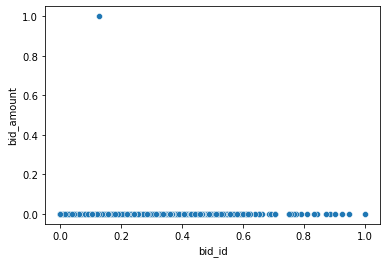

In [38]:

import seaborn as sns
sns.scatterplot(data=df_scaled, x="bid_id", y="bid_amount")